In [1]:
import ee 
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Autheticate and then initialize the session using your credentials
#ee.Authenticate()
ee.Initialize()

# A simple example that retrives a time series of a satellite image set and visualizes it

Note: While the image set corresponds to a time series progression, it is not clear what the time stamp of a particular image is

In [3]:
## Define your image collection 
collection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')

## Define time range and filter the data
collection_time = collection.filterDate('2000-01-01', '2018-01-01') #YYYY-MM-DD

## Select location based on location of tile
path = collection_time.filter(ee.Filter.eq('WRS_PATH', 198))
pathrow = path.filter(ee.Filter.eq('WRS_ROW', 24))

## Select imagery with less then 5% of image covered by clouds
clouds = pathrow.filter(ee.Filter.lt('CLOUD_COVER', 10))

## Select bands
bands = clouds.select(['B4', 'B5', 'B6'])


## Retrieve a list of the images
collectionList = bands.toList(bands.size()) # Converts the image collection to a list accessible via index
collectionSize = collectionList.size().getInfo()

# Get the information about the dates of this collection
collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['DATE_ACQUIRED'] for indx in range(collectionSize)]


print('='*100)
print('The number of items in this collection: ', collectionSize)
print()
print('Dates in the collection:')
print(collectionDates)
print('='*100)

# Define the region of interest
ROI = ee.Geometry.Rectangle([5.727906, 51.993435,
                                   5.588144, 51.944356])

# Choose a specific image from the collection List
indx = 0

image = ee.Image(collectionList.get(indx))

parameters = {'min': 0,
              'max': 0.5,
              'bands': ['B4', 'B5', 'B6'],
              'region': ROI }

# Plot the satellite image
Image(url = image.getThumbUrl(parameters))

The number of items in this collection:  16

Dates in the collection:
['2013-09-30', '2014-03-09', '2014-07-31', '2014-09-17', '2014-10-03', '2015-01-07', '2015-03-12', '2015-08-03', '2015-11-23', '2015-12-09', '2016-02-27', '2016-03-14', '2016-07-20', '2016-11-25', '2016-12-27', '2017-04-02']


# Having visualized the image, we now show how to convert it into a Numpy array so that we can manipulate the image

dict_keys(['type', 'bands', 'version', 'id', 'properties'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(194, 327, 3)


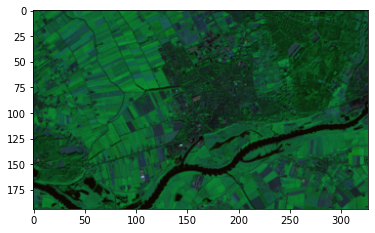

In [4]:
# Reference
# https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn


# Now that we have a specific image from the list, we convert it to a numpy array

indx = 0

# Retrieve the specific image
image = ee.Image(collectionList.get(indx))#

info = image.getInfo()
print(info.keys())#['DATE_ACQUIRED'])
#print(info['properties'])

# Define an area of interest.
aoi = ee.Geometry.Polygon([[[5.588144,51.993435], [5.727906, 51.993435],[5.727906, 51.944356],[5.588144, 51.944356]]], None, False)

# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = image.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B4')
band_arr_b5 = band_arrs.get('B5')
band_arr_b6 = band_arrs.get('B6')

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())

# Expand the dimensions of the arrays
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b4, np_arr_b5, np_arr_b6), 2)

print(rgb_img.shape)

# Plot the array
plt.imshow(rgb_img)
plt.show()

In [5]:

indx = 0

# Load a pre-computed Landsat composite for input.
input = ee.Image(collectionList.get(indx))

# Define a region in which to generate a sample of the input.
region =  ee.Geometry.Polygon([[[5.588144,51.993435], [5.727906, 51.993435],[5.727906, 51.944356],[5.588144, 51.944356]]], None, False)

#Map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')

# Make the training dataset.
training = input.sample(**{
  'region': region,
  'scale': 30,
  'numPixels': 5000
})

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(6).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer)

print(result.getInfo()['bands'])

[{'id': 'cluster', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'dimensions': [7791, 7911], 'crs': 'EPSG:32631', 'crs_transform': [30, 0, 527985, 0, -30, 5847015]}]


(194, 327)


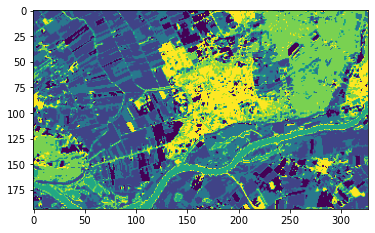

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


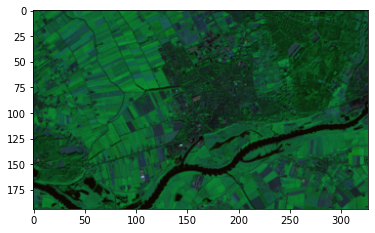

15989


In [14]:
# Define an area of interest.
aoi = ee.Geometry.Polygon([[[5.588144,51.993435], [5.727906, 51.993435],[5.727906, 51.944356],[5.588144, 51.944356]]], None, False)

# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = result.sampleRectangle(region=aoi)

data = np.array(band_arrs.get('cluster').getInfo())

print(data.shape)

#plt.plot(data)
plt.imshow(data)
plt.plot()
plt.show()

plt.clf()
plt.imshow(rgb_img)
plt.show()

print(np.sum(data.flatten()==1 ))